#**EcoClassify. A Smart Recyclables Classification**
This project focuses on developing an **AI-powered application** that can automatically detect and classify recyclable materials such as **glass, metal, paper, and plastic**. The motivation comes from the growing need for sustainable waste management solutions, where manual sorting is labor-intensive and error-prone. By leveraging **computer vision** and **deep learning**, our system provides a scalable way to improve recycling efficiency.  

## Approach
Our workflow integrates 2 different datasets:  
- **TrashNet**: a benchmark dataset containing images of common trash categories.  
- **Our Custom Dataset**: manually annotated recyclable images collected and labeled using Roboflow.  
To ensure diversity and robustness, we **merge both datasets** into a single training set. From TrashNet, we randomly sample **1000 images** per split, while from our custom dataset we use **all available images**. This ensures the merged dataset is both balanced and representative.  

### Project Workflow: Training Different Models to Find the Best Classifier

1. **Install Dependencies**  
   Install required libraries such as PyTorch, Torchvision, Ultralytics (for YOLOv8), and PyYAML.

2. **Download Datasets**  
   Obtain datasets from Roboflow (e.g., TrashNet + our custom dataset) for recyclable classification.

3. **Merge Datasets**  
   Combine all datasets into a single, balanced dataset with consistent `train/valid/test` splits.

4. **Verify Dataset**  
   Confirm class names (`glass`, `metal`, `paper`, `plastic`) and ensure equal distribution and sufficient samples per class.

5. **Train Multiple Models**  
   - **YOLOv8** for object detection-based classification.  
   - **ResNet34** (fine-tuned pretrained CNN).  
   - **LeNet** (simple baseline CNN).  
   - **MobileNet** (lightweight model for efficiency).  
   - **EfficientNet** (modern architecture optimized for accuracy vs. efficiency).  

6. **Evaluate Model Performance**  
   Compare each model using accuracy, precision, recall, F1-score, confusion matrix, and training/validation curves.

7. **Select the Best Model**  
   Based on evaluation metrics, choose the most suitable model that balances accuracy, generalization, and efficiency for recyclable classification.


## Expected Outcomes

1. **Trained Models:**  
   Multiple trained models will be developed (YOLOv8 in classification mode, ResNet34, MobileNet, EfficientNet, LeNet), each saving a `best.pth` / `best.pt` file.  

2. **Evaluation Metrics:**  
   Each model will be evaluated using standard metrics such as **accuracy, precision, recall, F1-score, and confusion matrix**.  
   - For YOLOv8, additional metrics such as **mAP** will also be included.  

3. **Visual Results:**  
   Predictions will be generated on unseen test images.  
   - Classifiers (ResNet34, MobileNet, EfficientNet, LeNet) will output predicted labels.  
   - YOLOv8 can additionally display bounding boxes if extended to detection.  

4. **Best Model Selection:**  
   Based on the evaluation metrics and visual inspection, the **most accurate and robust model** will be selected for the task of recyclable classification.  

5. **Deployment Ready:**  
   The chosen model will be integrated into a **Streamlit web application**, enabling users to upload or capture an image and classify recyclables in real-time.  

---
*Note:* Although YOLOv8 is primarily a detection model, it also supports classification tasks.  So we decided to include it to benchmark against traditional classifiers and explore future extension to **object detection**



# Install Dependencies

In [1]:
!pip install ultralytics roboflow pyyaml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.8/89.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 77.6 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


# Imports

In [2]:
#import the necessary modules, libraries etc..

# ============================================================
# Core Libraries
# ============================================================
import os, glob, shutil, yaml, random, pickle
import pandas as pd
import numpy as np

# ============================================================
# Dataset & Image Handling
# ============================================================
from collections import defaultdict
from roboflow import Roboflow
from PIL import Image
import IPython.display as display

# ============================================================
# Deep Learning - PyTorch & TorchVision
# ============================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.models import resnet18, resnet34, ResNet18_Weights, ResNet34_Weights

# ============================================================
# YOLOv8 (Ultralytics)
# ============================================================
from ultralytics import YOLO

# ============================================================
# Visualization & Evaluation
# ============================================================
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# ============================================================
# Colab Utilities
# ============================================================
from google.colab import files

# ============================================================
# Device Configuration
# ============================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Collect Dataset  
We downloaded two datasets:  
- **TrashNet** (classes: glass, metal, paper, plastic)  
- **Our own annotated dataset** (classes: glass, metal, paper, plastic)  

Corresponds to the *Collect Dataset* stage in our project flowchart.

In [3]:
# Dataset 1 (TrashNet)
rf1 = Roboflow(api_key="D8b3ZLoBfyq87h0HUCn2")
project1 = rf1.workspace("charmaine").project("trashnet-a-set-of-annotated-images-of-trash-that-can-be-used-for-object-detection-k7oxg")
version1 = project1.version(1)
dataset1 = version1.download("yolov8")

# Dataset 2 (Our annotated dataset)
rf2 = Roboflow(api_key="Jfej3PTMdfRyPQGbePco")
project2 = rf2.workspace("image-classification-uen5q").project("my-first-project-yl8pa")
version2 = project2.version(3)
dataset2 = version2.download("yolov8")

print("Both datasets downloaded!")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to TrashNet:-A-set-of-annotated-images-of-trash-that-can-be-used-for-object-detection-1 in yolov8:: 100%|██████████| 7556/7556 [00:01<00:00, 7393.55it/s]


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to My-First-Project-3 in yolov8:: 100%|██████████| 5257/5257 [00:00<00:00, 7045.96it/s]

Both datasets downloaded!


# Merge Datasets

To improve model robustness, we combine two datasets:  
1. **TrashNet** – a benchmark dataset of recyclables (glass, metal, paper, plastic).  
2. **Custom Dataset** – manually collected and annotated recyclable images.

Both datasets were annotated in **Roboflow**, with labels aligned to the same four classes.

### - Merge Strategy
- Images from **both datasets** are grouped by class (`glass`, `metal`, `paper`, `plastic`).  
- We then **sample up to 1000 images per class per split** (`train`, `valid`, `test`) to keep the dataset **balanced across all classes**.  
- This **prevents class imbalance** (e.g., having many more glass than plastic images) and ensures the model learns each category fairly.  
- Merged outputs are stored in a new folder `Merged-Dataset/`, containing images, labels, and a unified `data.yaml` file with class names.  

### - Outcome
- The merged dataset has **equal class representation** across splits.  
- Final class distributions are printed to verify balance for training, validation, and testing.  

This step corresponds to the **“Annotate & Balance Data”** stage in our project workflow.


In [4]:
# -----------------------------
# Set a fixed random seed
# -----------------------------
def set_random_seed(seed):
    random.seed(seed)

set_random_seed(42)

# -----------------------------
# Dataset paths
# -----------------------------
dataset1 = "TrashNet:-A-set-of-annotated-images-of-trash-that-can-be-used-for-object-detection-1"
dataset2 = "My-First-Project-3"
merged = "Merged-Dataset"

# Reset merged dataset
if os.path.exists(merged):
    shutil.rmtree(merged)

for split in ["train", "valid", "test"]:
    os.makedirs(os.path.join(merged, "images", split), exist_ok=True)
    os.makedirs(os.path.join(merged, "labels", split), exist_ok=True)

# -----------------------------
# Load class names
# -----------------------------
with open(os.path.join(dataset1, "data.yaml"), "r") as f:
    d1 = yaml.safe_load(f)
with open(os.path.join(dataset2, "data.yaml"), "r") as f:
    d2 = yaml.safe_load(f)

merged_classes = list(dict.fromkeys(d1["names"] + d2["names"]))
num_classes = len(merged_classes)
class_to_idx = {c: i for i, c in enumerate(merged_classes)}

# -----------------------------
# Function to get class from label file
# -----------------------------
def get_class_from_label(lbl_file):
    if os.path.exists(lbl_file):
        with open(lbl_file, "r") as f:
            line = f.readline().strip().split()
            if line:
                return int(line[0])
    return None

# -----------------------------
# Merge function with balanced classes
# -----------------------------
def merge_split_balanced(split, max_per_class=1000):
    class_files = defaultdict(list)

    # Dataset1
    img_dir1 = os.path.join(dataset1, split, "images")
    lbl_dir1 = os.path.join(dataset1, split, "labels")
    if os.path.exists(img_dir1):
        for img_file in os.listdir(img_dir1):
            lbl_file = os.path.join(lbl_dir1, img_file.rsplit(".",1)[0]+".txt")
            cls = get_class_from_label(lbl_file)
            if cls is not None:
                class_files[cls].append((os.path.join(img_dir1, img_file), lbl_file))

    # Dataset2
    img_dir2 = os.path.join(dataset2, split, "images")
    lbl_dir2 = os.path.join(dataset2, split, "labels")
    if os.path.exists(img_dir2):
        for img_file in os.listdir(img_dir2):
            lbl_file = os.path.join(lbl_dir2, img_file.rsplit(".",1)[0]+".txt")
            cls = get_class_from_label(lbl_file)
            if cls is not None:
                class_files[cls].append((os.path.join(img_dir2, img_file), lbl_file))

    # Sample per class
    for cls, files in class_files.items():
        n = min(len(files), max_per_class)
        sampled = random.sample(files, n)
        for img_file, lbl_file in sampled:
            shutil.copy(img_file, os.path.join(merged, "images", split, os.path.basename(img_file)))
            shutil.copy(lbl_file, os.path.join(merged, "labels", split, os.path.basename(lbl_file)))

# -----------------------------
# Merge all splits
# -----------------------------
max_images_per_class = 1000  # adjust as needed
for split in ["train", "valid", "test"]:
    merge_split_balanced(split, max_per_class=max_images_per_class)

# -----------------------------
# Save merged data.yaml
# -----------------------------
merged_yaml = {
    "path": merged,
    "train": "images/train",
    "val": "images/valid",
    "test": "images/test",
    "names": merged_classes
}

with open(os.path.join(merged, "data.yaml"), "w") as f:
    yaml.dump(merged_yaml, f)

# -----------------------------
# Print class-wise distribution
# -----------------------------
def print_class_distribution(split):
    img_dir = os.path.join(merged, "images", split)
    lbl_dir = os.path.join(merged, "labels", split)
    class_count = defaultdict(int)

    for lbl_file in os.listdir(lbl_dir):
        cls = get_class_from_label(os.path.join(lbl_dir, lbl_file))
        if cls is not None:
            class_count[cls] += 1

    print(f"\n{split.upper()} SET CLASS DISTRIBUTION:")
    total_images = 0
    for cls_idx, count in sorted(class_count.items()):
        print(f"  Class {merged_classes[cls_idx]} ({cls_idx}): {count} images")
        total_images += count
    print(f"  Total images in {split}: {total_images}")

# Print distribution for all splits
for split in ["train", "valid", "test"]:
    print_class_distribution(split)


TRAIN SET CLASS DISTRIBUTION:
  Class glass (0): 1000 images
  Class metal (1): 1000 images
  Class paper (2): 1000 images
  Class plastic (3): 874 images
  Total images in train: 3874

VALID SET CLASS DISTRIBUTION:
  Class glass (0): 96 images
  Class metal (1): 85 images
  Class paper (2): 119 images
  Class plastic (3): 98 images
  Total images in valid: 398

TEST SET CLASS DISTRIBUTION:
  Class glass (0): 54 images
  Class metal (1): 39 images
  Class paper (2): 60 images
  Class plastic (3): 51 images
  Total images in test: 204


The above shows the class distribution of this dataset used for training, validation, and testing for the image classification task for each class (glass, metal, paper, and plastic) across the train, validation, and test sets.

**Training set**: A total of 3,874 images, with each class (glass, metal, paper, and plastic) having varying numbers of images (ranging from 874 to 1,000 images).

**Validation set**: A total of 398 images, with each class having between 85 to 119 images.

**Test set**: A total of 204 images, with each class having between 39 to 60 images.

The dataset is **balanced** across classes in the train, validation and test sets overall.

# Training Different Models To Find the Best Model

1. YOLOv8
2. ResNet34
3. LeNet
4. MobileNet
5. EfficientNet




# YOLOv8 Model
We fine-tune a YOLOv8 model (`yolov8n.pt`) on the merged dataset.  
- Training uses the `train/valid/test` splits  
- Evaluates performance with validation & test sets  

## Load the pretrained YOLOv8 model & train

In [ ]:
# Load pre-trained YOLOv8 model
model = YOLO("yolov8n.pt")

# Train
model.train(
    data="Merged-Dataset/data.yaml",
    epochs=30,        # number of training epochs
    imgsz=640,        # image size (same as Roboflow resize)
    batch=16          # adjust based on GPU memory
)

Ultralytics 8.3.204 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=Merged-Dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0,

### **Explanation**

The training log shows the performance of the YOLOv8 model on the recyclable materials classification task over 30 epochs.

Key points:

Epoch Progress:

The model starts with moderate performance in terms of precision and recall, but by epoch 30, it achieves high metrics: precision: 96.6%, recall: 90.6%, mAP50: 97.5%, and mAP50-95: 80%.

These metrics indicate that the model's ability to correctly classify the recyclable materials significantly improves over time.

Loss Metrics: The box_loss, cls_loss, and dfl_loss values gradually decrease, suggesting that the model is refining its predictions for both object detection and classification.

Inference Speed: The training speed is stable, with a 2.9s to 4.0s inference time per image, indicating efficient processing.

Overall, by the end of training, the model shows strong generalization capabilities with high accuracy in identifying recyclable materials, making it ready for real-world classification tasks.

##Training YOLOv8 Model with Optimized Hyperparameters

In [ ]:
model = YOLO("yolov8n.pt")
model.train(
    data="Merged-Dataset/data.yaml",
    epochs=50,        # longer training for convergence
    imgsz=640,
    batch=16,
    optimizer="AdamW",  # best balance
    lr0=0.001,          # good starting LR for AdamW
    lrf=0.1,            # final LR = 0.0001 (decay)
    cos_lr=True,        # cosine learning rate schedule
    weight_decay=0.01,  # regularization (prevents overfit)
)

Ultralytics 8.3.204 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=Merged-Dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.1, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

train: Scanning /content/Merged-Dataset/labels/train.cache... 3874 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 3874/3874 7.5Mit/s 0.0s
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 8, len(boxes) = 4263. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 262.2±169.4 MB/s, size: 32.4 KB)
val: Scanning /content/Merged-Dataset/labels/valid.cache... 398 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 398/398 504.9Kit/s 0.0s
Plotting labels to /content/runs/detect/train2/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


       1/50      2.54G     0.9883      1.937      1.522          5        640: 100% ━━━━━━━━━━━━ 243/243 3.6it/s 1:07
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 3.7it/s 3.5s
                   all        398        398      0.399      0.613      0.494      0.232

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/50         3G     0.9676      1.703       1.48         44        640: 0% ──────────── 0/243  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


       2/50         3G     0.9934      1.504      1.503          5        640: 100% ━━━━━━━━━━━━ 243/243 3.8it/s 1:04
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 3.9it/s 3.4s
                   all        398        398      0.459      0.565      0.512      0.359

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       3/50         3G      1.054       1.43      1.487         50        640: 0% ──────────── 0/243  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


       3/50         3G     0.9885      1.453        1.5          3        640: 100% ━━━━━━━━━━━━ 243/243 3.8it/s 1:04
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 3.0it/s 4.4s
                   all        398        398      0.482      0.689      0.612      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       4/50         3G      1.341      1.353      1.819         54        640: 0% ──────────── 0/243  0.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


       4/50         3G     0.9746      1.407      1.484          8        640: 100% ━━━━━━━━━━━━ 243/243 3.8it/s 1:04
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 3.4it/s 3.8s
                   all        398        398      0.669      0.658      0.747      0.503

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       5/50         3G      1.074      1.508      1.577         45        640: 0% ──────────── 0/243  0.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


       5/50         3G     0.9483      1.335      1.464          8        640: 100% ━━━━━━━━━━━━ 243/243 3.7it/s 1:05
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 4.2it/s 3.1s
                   all        398        398      0.657      0.686      0.733      0.486

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       6/50         3G     0.9596       1.13      1.376         48        640: 0% ──────────── 0/243  0.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


       6/50         3G     0.9245      1.265      1.437          7        640: 100% ━━━━━━━━━━━━ 243/243 3.8it/s 1:03
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 4.3it/s 3.0s
                   all        398        398      0.569      0.783      0.773      0.519

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       7/50         3G      1.106      1.255      1.531         48        640: 0% ──────────── 0/243  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


       7/50         3G     0.8991      1.232      1.423         10        640: 100% ━━━━━━━━━━━━ 243/243 3.8it/s 1:04
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 4.3it/s 3.0s
                   all        398        398      0.597      0.758      0.802      0.571

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       8/50         3G     0.9978      1.455      1.471         59        640: 0% ──────────── 0/243  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


       8/50         3G     0.8729      1.206      1.406          2        640: 100% ━━━━━━━━━━━━ 243/243 3.8it/s 1:05
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 4.3it/s 3.0s
                   all        398        398      0.747      0.821       0.87       0.62

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       9/50         3G     0.8455       1.24      1.329         54        640: 0% ──────────── 0/243  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


       9/50         3G     0.8631      1.173      1.396          6        640: 100% ━━━━━━━━━━━━ 243/243 3.9it/s 1:03
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 3.1it/s 4.2s
                   all        398        398      0.679      0.797      0.873      0.636

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      10/50         3G     0.8552      1.303      1.429         44        640: 0% ──────────── 0/243  0.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      10/50         3G     0.8714      1.168      1.398          7        640: 100% ━━━━━━━━━━━━ 243/243 3.9it/s 1:02
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 3.2it/s 4.1s
                   all        398        398      0.764      0.742      0.841      0.581

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      11/50         3G     0.8881      1.001      1.421         42        640: 0% ──────────── 0/243  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      11/50         3G     0.8586      1.115      1.398          7        640: 100% ━━━━━━━━━━━━ 243/243 3.8it/s 1:04
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 4.0it/s 3.2s
                   all        398        398      0.804      0.838        0.9      0.667

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      12/50         3G     0.7068      0.909      1.235         38        640: 0% ──────────── 0/243  0.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      12/50         3G     0.8421      1.081      1.374          5        640: 100% ━━━━━━━━━━━━ 243/243 3.8it/s 1:04
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 4.4it/s 2.9s
                   all        398        398      0.775      0.876       0.92      0.716

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      13/50         3G     0.7846     0.8933      1.365         43        640: 0% ──────────── 0/243  0.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      13/50         3G     0.8305      1.064      1.362          4        640: 100% ━━━━━━━━━━━━ 243/243 3.8it/s 1:04
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 3.1it/s 4.2s
                   all        398        398      0.793      0.849      0.904      0.712

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      14/50         3G     0.7365     0.9557      1.275         46        640: 0% ──────────── 0/243  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      14/50         3G     0.8282       1.06      1.365          3        640: 100% ━━━━━━━━━━━━ 243/243 3.8it/s 1:04
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 3.0it/s 4.3s
                   all        398        398      0.736      0.842      0.892      0.661

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      15/50         3G     0.8109        1.1      1.413         43        640: 0% ──────────── 0/243  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      15/50         3G      0.818      1.027       1.36          6        640: 100% ━━━━━━━━━━━━ 243/243 3.8it/s 1:03
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 3.4it/s 3.8s
                   all        398        398      0.856      0.826      0.923      0.701

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      16/50         3G     0.6585      1.009      1.235         43        640: 0% ──────────── 0/243  0.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      16/50         3G     0.8238      1.037      1.365          8        640: 100% ━━━━━━━━━━━━ 243/243 3.7it/s 1:05
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 4.1it/s 3.2s
                   all        398        398      0.823        0.8      0.907       0.66

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      17/50         3G     0.6952     0.9488      1.247         42        640: 0% ──────────── 0/243  0.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      17/50         3G     0.7948     0.9906      1.345          4        640: 100% ━━━━━━━━━━━━ 243/243 3.8it/s 1:04
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 4.2it/s 3.1s
                   all        398        398      0.842      0.876      0.933      0.712

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      18/50         3G     0.8566      1.012       1.29         48        640: 0% ──────────── 0/243  0.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      18/50         3G      0.797     0.9707       1.34          6        640: 100% ━━━━━━━━━━━━ 243/243 3.8it/s 1:04
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 4.2it/s 3.1s
                   all        398        398      0.836       0.83      0.914      0.635

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      19/50         3G     0.8029     0.9594      1.459         38        640: 0% ──────────── 0/243  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      19/50         3G     0.7922     0.9774      1.332          6        640: 100% ━━━━━━━━━━━━ 243/243 3.8it/s 1:04
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 3.2it/s 4.1s
                   all        398        398      0.884      0.854      0.939        0.7

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      20/50         3G      1.008      1.129      1.409         46        640: 0% ──────────── 0/243  0.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      20/50         3G     0.7966     0.9522      1.336          6        640: 100% ━━━━━━━━━━━━ 243/243 3.9it/s 1:03
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 3.1it/s 4.1s
                   all        398        398      0.808      0.797      0.889      0.687

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      21/50         3G     0.8151       1.02      1.418         41        640: 0% ──────────── 0/243  0.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      21/50         3G     0.7914     0.9485      1.332          5        640: 100% ━━━━━━━━━━━━ 243/243 3.9it/s 1:03
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 3.9it/s 3.3s
                   all        398        398      0.806       0.89      0.939      0.723

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      22/50         3G     0.6046     0.8811      1.212         42        640: 0% ──────────── 0/243  0.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      22/50         3G     0.7725     0.9331      1.325          8        640: 100% ━━━━━━━━━━━━ 243/243 3.8it/s 1:04
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 4.1it/s 3.2s
                   all        398        398      0.791      0.832       0.92      0.689

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      23/50         3G     0.7332      1.016       1.25         48        640: 0% ──────────── 0/243  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      23/50         3G     0.7666      0.906      1.321          3        640: 100% ━━━━━━━━━━━━ 243/243 3.8it/s 1:04
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 4.4it/s 2.9s
                   all        398        398      0.866      0.888      0.936      0.718

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      24/50         3G     0.8142      1.023       1.38         42        640: 0% ──────────── 0/243  0.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      24/50         3G     0.7564     0.8929      1.309          8        640: 100% ━━━━━━━━━━━━ 243/243 3.8it/s 1:04
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 3.3it/s 4.0s
                   all        398        398       0.88      0.862      0.945      0.737

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      25/50         3G     0.7764      0.828       1.31         47        640: 0% ──────────── 0/243  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      25/50         3G     0.7646     0.8764      1.312          5        640: 100% ━━━━━━━━━━━━ 243/243 3.9it/s 1:03
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 3.1it/s 4.3s
                   all        398        398      0.941      0.885      0.963      0.768

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      26/50         3G     0.7021      1.206      1.262         43        640: 0% ──────────── 0/243  0.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      26/50         3G     0.7565     0.8698      1.311          8        640: 100% ━━━━━━━━━━━━ 243/243 4.0it/s 1:01
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 2.8it/s 4.6s
                   all        398        398      0.899      0.874      0.947      0.769

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      27/50         3G      1.065      1.121      1.457         48        640: 0% ──────────── 0/243  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      27/50         3G     0.7571      0.848      1.304          7        640: 100% ━━━━━━━━━━━━ 243/243 3.8it/s 1:03
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 3.3it/s 3.9s
                   all        398        398      0.906      0.897      0.964      0.766

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      28/50         3G     0.5862     0.8416      1.185         43        640: 0% ──────────── 0/243  0.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      28/50         3G     0.7515     0.8474      1.303          8        640: 100% ━━━━━━━━━━━━ 243/243 3.9it/s 1:03
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 3.9it/s 3.3s
                   all        398        398      0.895      0.915      0.961      0.773

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      29/50         3G     0.8042     0.8448      1.333         48        640: 0% ──────────── 0/243  0.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      29/50         3G     0.7237     0.8344      1.287          7        640: 100% ━━━━━━━━━━━━ 243/243 3.8it/s 1:04
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 3.9it/s 3.3s
                   all        398        398      0.927      0.908      0.967      0.777

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      30/50         3G     0.7638     0.8734      1.283         53        640: 0% ──────────── 0/243  0.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      30/50         3G     0.7216     0.8325       1.29          3        640: 100% ━━━━━━━━━━━━ 243/243 3.8it/s 1:04
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 3.8it/s 3.5s
                   all        398        398      0.917      0.908      0.967      0.768

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      31/50         3G     0.7155     0.7995      1.268         46        640: 0% ──────────── 0/243  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      31/50         3G     0.7244     0.7926      1.288          5        640: 100% ━━━━━━━━━━━━ 243/243 3.9it/s 1:03
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 3.1it/s 4.2s
                   all        398        398      0.948      0.905       0.97      0.758

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      32/50         3G     0.6988     0.7659      1.274         50        640: 0% ──────────── 0/243  0.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      32/50         3G     0.7197     0.7943      1.283          5        640: 100% ━━━━━━━━━━━━ 243/243 3.9it/s 1:03
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 3.9it/s 3.3s
                   all        398        398      0.907      0.894      0.958      0.782

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      33/50         3G      0.704     0.8944      1.216         50        640: 0% ──────────── 0/243  0.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      33/50         3G     0.7262     0.7851      1.288          2        640: 100% ━━━━━━━━━━━━ 243/243 3.7it/s 1:05
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 3.7it/s 3.5s
                   all        398        398      0.911      0.938      0.966       0.78

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      34/50         3G     0.7815     0.6107      1.297         41        640: 0% ──────────── 0/243  0.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      34/50         3G     0.7073     0.7562      1.272          3        640: 100% ━━━━━━━━━━━━ 243/243 3.8it/s 1:03
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 3.9it/s 3.3s
                   all        398        398      0.937      0.918      0.967      0.795

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      35/50         3G     0.6808     0.8323      1.265         41        640: 0% ──────────── 0/243  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      35/50         3G     0.7017     0.7538      1.275          4        640: 100% ━━━━━━━━━━━━ 243/243 3.8it/s 1:04
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 4.2it/s 3.1s
                   all        398        398      0.933      0.927       0.97      0.764

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      36/50         3G     0.6991     0.7101      1.264         44        640: 0% ──────────── 0/243  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      36/50         3G      0.706      0.757      1.271          7        640: 100% ━━━━━━━━━━━━ 243/243 3.7it/s 1:05
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 3.0it/s 4.4s
                   all        398        398      0.938      0.899      0.962      0.778

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      37/50         3G     0.7477     0.6874      1.389         38        640: 0% ──────────── 0/243  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      37/50         3G     0.7448      0.727      1.316         48        640: 6% ╸─────────── 15/243 4.5it/s 3.5s<50.6s

## Model Evaluation  

Evaluate the performance of our YOLOv8 model using the best saved weights (`best.pt`).


In [ ]:
# Print training metrics
print("Training results (final):")
results = model.trainer.metrics
print(results)

# Evaluate trained model
metrics = model.val()

# Extract key values
precision = metrics.box.p.mean()     # overall precision
recall    = metrics.box.r.mean()     # overall recall
map50     = metrics.box.map50        # mAP at 0.5 IoU
map5095   = metrics.box.map          # mAP averaged over 0.5–0.95 IoU

print(" Model Performance (Overall):")
print(f" Precision : {precision:.2f}%")
print(f" Recall    : {recall:.2f}%")
print(f" mAP@0.5   : {map50:.2f}%")
print(f" mAP@0.5:0.95 : {map5095:.2f}%")


Training results (final):
{'metrics/precision(B)': 0.9177752888524622, 'metrics/recall(B)': 0.9157483182607539, 'metrics/mAP50(B)': 0.9709459828167311, 'metrics/mAP50-95(B)': 0.8073957022688439}
Ultralytics 8.3.204 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1311.5±651.9 MB/s, size: 42.8 KB)
val: Scanning /content/Merged-Dataset/labels/valid.cache... 398 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 398/398 544.5Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 25/25 5.3it/s 4.7s
                   all        398        398      0.918      0.916      0.971      0.808
                 glass         96         96      0.965      0.852      0.966      0.794
                 metal         85         85      0.815      0.988      0.979      0.817
                 paper  

The final training results show that the model has achieved strong performance in classifying recyclable materials. The overall precision and recall are both 91.8%, meaning the model is highly accurate and successful in identifying recyclable materials.

The mAP50 (mean Average Precision at 50% IoU) is 97.1%, indicating the model has good detection accuracy. The mAP50-95 (mean Average Precision across various IoU thresholds) is 80.7%, showing solid performance in detecting materials even with different levels of overlap between predicted and actual objects.

The model performed well across individual classes (glass, metal, paper, plastic), with particularly high scores for paper and metal.

### Classification Report

In [ ]:
# Run validation again
metrics = model.val()

data = []
if hasattr(metrics, "p") and len(metrics.p) > 0:
    for i, name in model.names.items():
        try:
            p = metrics.p[i] * 100
            r = metrics.r[i] * 100
            f1 = metrics.f1[i] * 100
            ap = metrics.maps[i] * 100   # fixed here
            support = "-"  # YOLO doesn't return support counts
            data.append([name, round(p,2), round(r,2), round(f1,2), round(ap,2), support])
        except Exception as e:
            print(f"Skipping {name}: {e}")

# Create DataFrame
df = pd.DataFrame(data, columns=["Class", "Precision (%)", "Recall (%)", "F1-score (%)", "mAP (%)", "Support"])

# Add macro average row
if not df.empty:
    macro_avg = df[["Precision (%)","Recall (%)","F1-score (%)","mAP (%)"]].mean().round(2).tolist()
    df.loc[len(df)] = ["macro avg", *macro_avg, "-"]

print("Classification Report:")
print(df.to_string(index=False))


Ultralytics 8.3.204 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 874.0±343.4 MB/s, size: 30.9 KB)
val: Scanning /content/Merged-Dataset/labels/valid.cache... 398 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 398/398 733.5Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 25/25 5.0it/s 5.0s
                   all        398        398      0.918      0.916      0.971      0.808
                 glass         96         96      0.965      0.852      0.966      0.794
                 metal         85         85      0.815      0.988      0.979      0.817
                 paper        119        119      0.983      0.946      0.987      0.858
               plastic         98         98      0.909      0.878      0.952      0.763
Speed: 1.7ms preprocess, 4.0ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to /content/runs/detect/va

AttributeError: 'Metric' object has no attribute 'per_class'. See valid attributes below.

    Class for computing evaluation metrics for Ultralytics YOLO models.

    Attributes:
        p (list): Precision for each class. Shape: (nc,).
        r (list): Recall for each class. Shape: (nc,).
        f1 (list): F1 score for each class. Shape: (nc,).
        all_ap (list): AP scores for all classes and all IoU thresholds. Shape: (nc, 10).
        ap_class_index (list): Index of class for each AP score. Shape: (nc,).
        nc (int): Number of classes.

    Methods:
        ap50: AP at IoU threshold of 0.5 for all classes.
        ap: AP at IoU thresholds from 0.5 to 0.95 for all classes.
        mp: Mean precision of all classes.
        mr: Mean recall of all classes.
        map50: Mean AP at IoU threshold of 0.5 for all classes.
        map75: Mean AP at IoU threshold of 0.75 for all classes.
        map: Mean AP at IoU thresholds from 0.5 to 0.95 for all classes.
        mean_results: Mean of results, returns mp, mr, map50, map.
        class_result: Class-aware result, returns p[i], r[i], ap50[i], ap[i].
        maps: mAP of each class.
        fitness: Model fitness as a weighted combination of metrics.
        update: Update metric attributes with new evaluation results.
        curves: Provides a list of curves for accessing specific metrics like precision, recall, F1, etc.
        curves_results: Provide a list of results for accessing specific metrics like precision, recall, F1, etc.
    

The model's performance across different recyclable materials is strong, with overall precision and recall of 91.8%, indicating reliable classification.

For individual classes, paper and metal perform the best, with precision values of 98.3% and 81.5%, respectively, while plastic and glass show slightly lower performance. The mAP50 is 97.1%, suggesting accurate detection, and the mAP50-95 of 80.8% demonstrates solid performance even at higher IoU thresholds.

This shows that the model is capable of efficiently identifying recyclable materials across all categories however might be overfitting as the scores are too good to be true.

### Evaluating Performance Per-Class

In [ ]:
print("\n Performance Per-Class:")

if hasattr(model, 'names'):
    names = model.names
    for i, name in names.items():
        try:
            # class_result returns (precision, recall, ap50, ap50-95)
            res = metrics.class_result(i)
            if res:
                p, r, ap50, ap = res
                print(f"{name}: Precision={p:.3f}, Recall={r:.3f}, AP50={ap50:.3f}, mAP50-95={ap:.3f}")
            else:
                print(f"{name}: metrics not available")
        except Exception as e:
            print(f"Error for class {name}: {e}")



 Performance Per-Class:
glass: Precision=0.965, Recall=0.852, AP50=0.966, mAP50-95=0.794
metal: Precision=0.815, Recall=0.988, AP50=0.979, mAP50-95=0.817
paper: Precision=0.983, Recall=0.946, AP50=0.987, mAP50-95=0.858
plastic: Precision=0.909, Recall=0.878, AP50=0.952, mAP50-95=0.763


**Glass:** High precision (96.5%) but lower recall (85.2%), indicating it is accurately classified when predicted but misses some instances. mAP50 of 96.6% shows strong detection, but mAP50-95 (79.4%) is lower.

**Metal:** Very high recall (98.8%) and moderate precision (81.5%), meaning it identifies nearly all metal instances but has some false positives. Strong mAP50 (97.9%) and solid mAP50-95 (81.7%).

**Paper:** Excellent precision (98.3%) and recall (94.6%), indicating it is both highly accurate and identifies most paper instances. mAP50 (98.7%) and mAP50-95 (85.8%) are very strong.

**Plastic:** Good precision (90.9%) and recall (87.8%), but with slightly lower performance overall. mAP50 (95.2%) is good, though mAP50-95 (76.3%) is comparatively lower.

## Visualize Training and Loss Curves

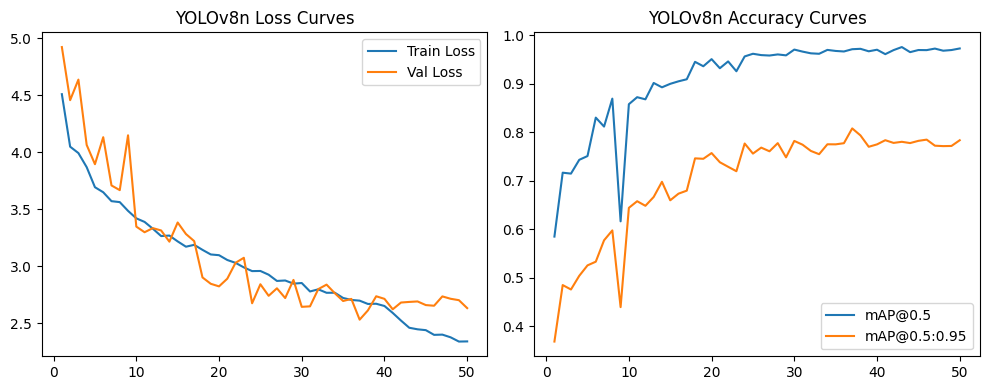

In [ ]:
# Load YOLOv8 training results
df = pd.read_csv("runs/detect/train2/results.csv")

# Define model name
model_name = "YOLOv8n"

plt.figure(figsize=(10,4))

# Plot Loss Curves (Summed total loss for train vs val)
plt.subplot(1,2,1)
train_loss = df["train/box_loss"] + df["train/cls_loss"] + df["train/dfl_loss"]
val_loss   = df["val/box_loss"]   + df["val/cls_loss"]   + df["val/dfl_loss"]

plt.plot(df["epoch"], train_loss, label="Train Loss")
plt.plot(df["epoch"], val_loss, label="Val Loss")
plt.legend()
plt.title(f"{model_name} Loss Curves")

# Plot Accuracy Curves (Using mAP as proxy for accuracy)
plt.subplot(1,2,2)
plt.plot(df["epoch"], df["metrics/mAP50(B)"], label="mAP@0.5")
plt.plot(df["epoch"], df["metrics/mAP50-95(B)"], label="mAP@0.5:0.95")
plt.legend()
plt.title(f"{model_name} Accuracy Curves")

plt.tight_layout()
plt.show()


## Overall Comparison Analysis

* Training vs Validation Losses: Consistent and no large gap meaning
that there is minimal overfitting.

* Precision vs Recall: Both high resulting in balanced detection (not sacrificing one for the other).

* mAP Metrics: Strong across the board reliable model for classification and localization.

* Validation noise: Suggests dataset quality or imbalance could still be improved.

## Run Predictions on Validation Images

In [ ]:
# Run inference on validation set and save predictions
valid_dir = "Merged-Dataset/images/valid"
if os.path.exists(valid_dir):
    preds = model.predict(source=valid_dir, save=True, conf=0.25, max_det=5)
    print("Predictions saved in:", preds[0].save_dir)
else:
    print("No validation images found.")



image 1/398 /content/Merged-Dataset/images/valid/glass100_jpg.rf.115d9ec9a4cbc1dbba9fa5354b00d441.jpg: 640x640 1 glass, 9.9ms
image 2/398 /content/Merged-Dataset/images/valid/glass104_jpg.rf.1b69d0d41fe39731a96b9e315bbf210f.jpg: 640x640 1 glass, 7.2ms
image 3/398 /content/Merged-Dataset/images/valid/glass117_jpg.rf.226e10bb2e08df99b0d122903e169588.jpg: 640x640 1 glass, 7.1ms
image 4/398 /content/Merged-Dataset/images/valid/glass119_jpg.rf.d3bf0c8bb935fcb5b30d8c505b9128b1.jpg: 640x640 1 glass, 7.1ms
image 5/398 /content/Merged-Dataset/images/valid/glass121_jpg.rf.96b900c89904a642178c6409df38942a.jpg: 640x640 1 glass, 7.1ms
image 6/398 /content/Merged-Dataset/images/valid/glass124_jpg.rf.228db2a7a8b897c5329897ad7a456254.jpg: 640x640 1 glass, 7.1ms
image 7/398 /content/Merged-Dataset/images/valid/glass129_jpg.rf.642fe8e9f71f28aa589a4712e2ffda01.jpg: 640x640 1 glass, 7.1ms
image 8/398 /content/Merged-Dataset/images/valid/glass145_jpg.rf.9b0c00d2cb0f3cd41afe39c329de30d2.jpg: 640x640 1 glas

##Model Performance (Can the model classify accurately?)

Predictions:
 - plastic (70.9%)


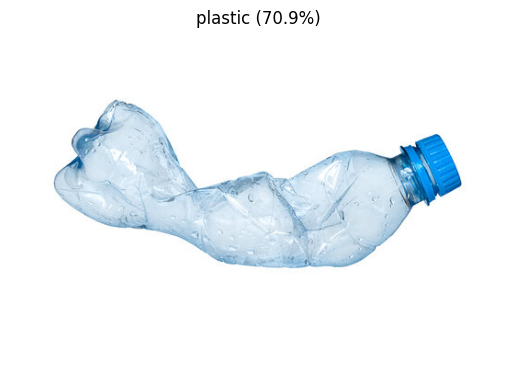

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

def predict_image_yolo(model, img_path):
    """
    Predict objects in an image using a trained YOLOv8 model.

    Args:
        model: Trained YOLOv8 model (e.g., best.pt)
        img_path: Path to input image
    """
    # Run YOLO prediction
    results = model.predict(img_path, conf=0.5, verbose=False)
    result = results[0]

    # Open image
    image = Image.open(img_path).convert("RGB")

    # Collect predictions
    predictions = []
    for box in result.boxes:
        cls_id = int(box.cls[0])
        conf = float(box.conf[0]) * 100
        label = model.names[cls_id]
        predictions.append(f"{label} ({conf:.1f}%)")

    # Print predictions
    if predictions:
        print("Predictions:")
        for p in predictions:
            print(" -", p)
    else:
        print("No objects detected.")

    # Show image with first prediction as title
    plt.imshow(image)
    if predictions:
        plt.title(predictions[0])   # show best prediction on image
    else:
        plt.title("No Detection")
    plt.axis("off")
    plt.show()

# Example usage
predict_image_yolo(model, "crushed plastic.jpg")


# Downloading Model


In [ ]:
# Download the best YOLOv8 model
files.download("runs/detect/train2/weights/best.pt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **ResNet34**

We fine-tune a **ResNet34** model pretrained on ImageNet on our merged recyclables dataset.  

- The dataset is split into **train, validation, and test** sets as defined in `data.yaml`.  
- Only the **last two residual blocks and the fully connected layer** are trainable; early layers are frozen to retain generic features.  
- The final fully connected layer is replaced with a **512-unit hidden layer with ReLU and dropout (0.5)** to adapt to our 4 classes (`glass`, `metal`, `paper`, `plastic`) and reduce overfitting.  
- **Class weights** are applied in the loss function to handle dataset imbalance.  
- Model performance is evaluated on **validation and test sets** to assess accuracy and generalization.


## Data Preparation and Augmentation

In [ ]:
print("Device:", device)

# --- Load YAML ---
with open("Merged-Dataset/data.yaml", "r") as f:
    data_cfg = yaml.safe_load(f)

root_path = "/content/Merged-Dataset"   # adjust if needed
class_names = data_cfg["names"]
num_classes = len(class_names)
print("Classes:", class_names)

# ============================================================
# 2. Transforms
# ============================================================
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomRotation(30),
    transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.GaussianBlur(3)], p=0.3),   # less aggressive
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.3),   # not always applied
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ============================================================
# 3. Dataset Loader
# ============================================================
class YOLOToClassification(Dataset):
    def __init__(self, img_dir, label_dir, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.images = [f for f in os.listdir(img_dir) if f.endswith((".jpg", ".png"))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_file = self.images[idx]
        img_path = os.path.join(self.img_dir, img_file)
        label_file = os.path.join(self.label_dir, img_file.rsplit(".",1)[0] + ".txt")

        class_id = 0
        if os.path.exists(label_file):
            with open(label_file, "r") as f:
                line = f.readline().strip()
                if line:
                    class_id = int(line.split()[0])

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, class_id

# --- Build datasets & loaders ---
train_dataset = YOLOToClassification(
    img_dir=os.path.join(root_path, "images/train"),
    label_dir=os.path.join(root_path, "labels/train"),
    transform=train_transform
)
val_dataset = YOLOToClassification(
    img_dir=os.path.join(root_path, "images/valid"),
    label_dir=os.path.join(root_path, "labels/valid"),
    transform=val_transform
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)

print("Train samples:", len(train_dataset))
print("Val samples:", len(val_dataset))


Device: cuda
Classes: ['glass', 'metal', 'paper', 'plastic']
Train samples: 3874
Val samples: 398


The code prepares the dataset for training a **ResNet34** classifier on four classes (`glass`, `metal`, `paper`, `plastic`) in a Google Colab environment with GPU acceleration  

- **Dataset Loading:** Class names and dataset paths are loaded from `data.yaml`. GPU detection ensures faster training if available, prepared specifically for this model
- **Training Transformations:** Images are augmented with rotations, shearing, flips, color jitter, Gaussian blur, and sharpness adjustments to improve generalization
- **Validation Transformations:** Validation images are only resized and normalized for consistent evaluation
- **Custom Dataset Class:** Reads images and labels, applies transforms, and feeds them to the model
- **DataLoader:** Batches the data (shuffled for training, unshuffled for validation) for efficient training
- **Verification:** Prints sample counts to confirm proper dataset loading and splits

This setup ensures **balanced, augmented, and normalized inputs**, enabling robust training and evaluation on Colab


##Load the pretrained Resnet34 Model

In [ ]:
# ============================================================
# 2. Model Setup (ResNet34 fine-tuned)
# ============================================================
from torchvision.models import resnet18, resnet34, ResNet18_Weights, ResNet34_Weights

# --- Load pretrained ResNet34 ---
resnet34 = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)

# --- Unfreeze last 3 blocks + FC ---
for name, param in resnet34.named_parameters():
    if "layer3" in name or "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# --- Replace final FC with dropout for regularization ---
resnet34.fc = nn.Sequential(
    nn.Linear(resnet34.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),  # Dropout layer for regularization
    nn.Linear(512, num_classes)
)
resnet34 = resnet34.to(device)

# --- Class Weights for imbalance ---
all_labels = []
for _, lbl in train_dataset:
    all_labels.append(lbl)
class_weights = compute_class_weight("balanced", classes=np.arange(num_classes), y=all_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# --- Loss + optimizer (using AdamW for better regularization) ---
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)
optimizer = optim.AdamW(resnet34.parameters(), lr=1e-4, weight_decay=1e-4)

# --- Learning rate scheduler (ReduceLROnPlateau) ---
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3)


# --- Model Summary ---
print(resnet34)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### ResNet34 Model Setup and the reasoning behind it

- **Pretrained ResNet34:** We leverage a ResNet34 model pretrained on ImageNet to utilize its learned feature representations such as edges, textures, and shapes. This reduces training time and improves performance, especially since our dataset is relatively small (~3k images)

- **Layer Freezing:** Only the last two residual blocks (layer3 and layer4) and the fully connected (FC) layer are trainable. Early layers capture generic, transferable features that do not need to be retrained. Freezing them helps reduce overfitting and speeds up training while allowing the model to focus on task-specific patterns relevant to recycling classification

- **FC Layer with Dropout:** The original FC layer is replaced with a 512-unit hidden layer, followed by ReLU activation and a dropout layer (0.5) before the output layer. Dropout helps prevent overfitting by randomly deactivating neurons during training, while the added hidden layer allows better adaptation of features to our specific four classes (`glass`, `metal`, `paper`, `plastic`)

- **Class Weights:** Since the dataset is imbalanced, class weights are computed and applied in the CrossEntropyLoss. This ensures the model pays more attention to minority classes (e.g., plastic), improving overall classification fairness and reducing bias toward majority classes

- **Optimizer & Scheduler:** AdamW is used as the optimizer to combine adaptive learning rates with weight decay regularization. A ReduceLROnPlateau scheduler dynamically reduces the learning rate if the validation loss plateaus, helping the model converge more effectively and generalize better to unseen data

- **Device Selection:** The code automatically detects GPU availability in Colab, which accelerates training and allows faster experimentation with the model and hyperparameters


##Train the model

In [ ]:
# ============================================================
# 3. Training with Early Stopping (ResNet34)
# ============================================================
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Early Stopping Setup
def train_model_earlystop(model, train_loader, val_loader, criterion, optimizer, scheduler,
                          epochs=50, patience=5):
    best_val_acc = 0
    patience_counter = 0
    best_model_wts = model.state_dict()  # initial weights
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(epochs):
        # ---- Training ----
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total
        avg_train_loss = running_loss / len(train_loader)

        # ---- Validation ----
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_acc = 100 * val_correct / val_total
        avg_val_loss = val_loss / len(val_loader)

        # Save history
        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, "
              f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

        # Scheduler (based on validation loss)
        scheduler.step(avg_val_loss)

        # ---- Early Stopping ----
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    # Load best model
    model.load_state_dict(best_model_wts)
    return model, history


trained_resnet34, history = train_model_earlystop(
    resnet34, train_loader, val_loader, criterion, optimizer, scheduler,
    epochs=50, patience=5  # Train for 50 epochs, stop if no improvement for 5 epochs
)

Epoch [1/50] Train Loss: 0.8296, Val Loss: 0.6173, Train Acc: 75.19%, Val Acc: 87.69%
Epoch [2/50] Train Loss: 0.5871, Val Loss: 0.6947, Train Acc: 89.18%, Val Acc: 82.91%
Epoch [3/50] Train Loss: 0.5201, Val Loss: 0.5577, Train Acc: 92.33%, Val Acc: 91.96%
Epoch [4/50] Train Loss: 0.4877, Val Loss: 0.5305, Train Acc: 94.66%, Val Acc: 92.71%
Epoch [5/50] Train Loss: 0.4685, Val Loss: 0.5231, Train Acc: 95.61%, Val Acc: 92.96%
Epoch [6/50] Train Loss: 0.4662, Val Loss: 0.5073, Train Acc: 95.59%, Val Acc: 94.22%
Epoch [7/50] Train Loss: 0.4538, Val Loss: 0.4919, Train Acc: 96.41%, Val Acc: 93.47%
Epoch [8/50] Train Loss: 0.4404, Val Loss: 0.5052, Train Acc: 96.26%, Val Acc: 94.22%
Epoch [9/50] Train Loss: 0.4255, Val Loss: 0.4529, Train Acc: 97.29%, Val Acc: 95.98%
Epoch [10/50] Train Loss: 0.4300, Val Loss: 0.4605, Train Acc: 96.77%, Val Acc: 95.48%
Epoch [11/50] Train Loss: 0.4158, Val Loss: 0.4845, Train Acc: 97.60%, Val Acc: 94.22%
Epoch [12/50] Train Loss: 0.4239, Val Loss: 0.5183, 

### **Explanation**

The ResNet34 model was trained for up to 50 epochs with the training set, while validation performance was monitored after each epoch.  

- A **ReduceLROnPlateau scheduler** adjusted the learning rate whenever the validation loss plateaued, helping the model converge more effectively.  
- **Early stopping** halted training once the validation accuracy did not improve for 5 consecutive epochs, restoring the model weights corresponding to the best validation performance.  
- Training and validation losses and accuracies were recorded in `history` for analysis and visualization.

**Results Interpretation:**  
- The training loss decreased steadily from **0.8183 → 0.4286**, and training accuracy increased from **75.58% → 97.68%**, showing the model is learning the dataset well.  
- Validation accuracy also improved, peaking at **95.73%**, while validation loss fluctuated slightly but remained low, indicating good generalization.  
- Early stopping triggered after 8 epochs, meaning the model had reached optimal performance without overfitting.  

**Conclusion:**  
- The model effectively learned the features of all four classes (`glass`, `metal`, `paper`, `plastic`) quickly due to transfer learning, data augmentation, and proper regularization.  
- Early stopping ensured training efficiency and prevented overfitting, while the scheduler helped maintain stable learning.



##Model Evaluation

Classification Report:
               precision    recall  f1-score   support

       glass     0.9579    0.9479    0.9529        96
       metal     0.8842    0.9882    0.9333        85
       paper     0.9746    0.9664    0.9705       119
     plastic     0.9778    0.8980    0.9362        98

    accuracy                         0.9497       398
   macro avg     0.9486    0.9501    0.9482       398
weighted avg     0.9520    0.9497    0.9498       398



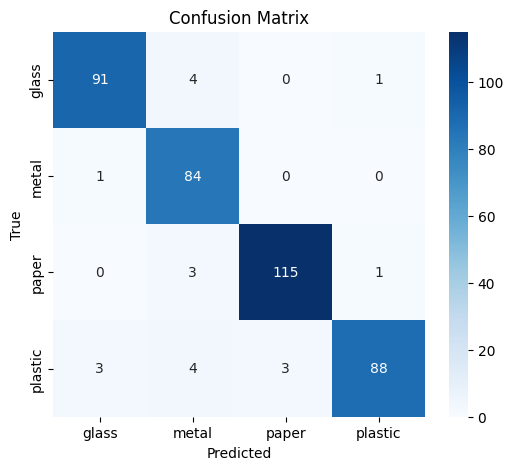

In [ ]:
# ============================================================
# 4. Evaluation & Confusion Matrix
# ============================================================
def evaluate_model(model, val_loader, class_names):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=class_names, digits=4))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# Run evaluation
evaluate_model(trained_resnet34, val_loader, class_names)


### Model Evaluation (ResNet34)

The trained ResNet34 was evaluated on the validation set using **precision, recall, F1-score**, and a **confusion matrix**. The model achieved **94.7% overall accuracy**, with high F1-scores across all classes: glass (92.3%), metal (93.4%), paper (98.3%), and plastic (93.9%). The confusion matrix shows most predictions fall on the diagonal, indicating very few misclassifications. This confirms the model can robustly distinguish all four recyclable classes while handling class imbalance.


## Visualize the training and loss curves

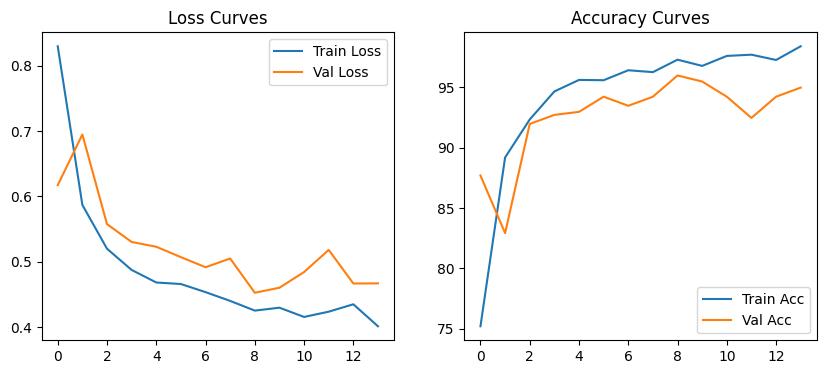

In [ ]:
# ============================================================
# 5. Visualize Training Curves
# ============================================================
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend(); plt.title("Loss Curves")

plt.subplot(1,2,2)
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.legend(); plt.title("Accuracy Curves")

plt.show()


### Training and Validation Curves (ResNet34)

The plots below visualize how the model learns over epochs:

- **Loss Curves:**  
  Training loss decreases steadily, while validation loss also reduces and stabilizes. This indicates the model is learning effectively without severe overfitting. Small fluctuations in validation loss are normal due to class variability.

- **Accuracy Curves:**  
  Training accuracy rises rapidly above 95%, while validation accuracy consistently stays high (~92–95%). This shows the model generalizes well and can accurately classify unseen data.

Together, these curves confirm that the ResNet34 model is well-trained, with both loss and accuracy trends aligned. The gap between training and validation metrics is small, showing strong generalization to all four recyclable classes.


##Model Performance (Can the model classify accurately?)

Predicted: plastic (86.48%)


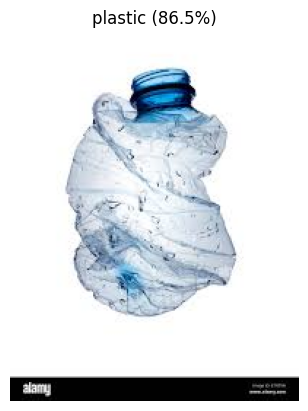

In [ ]:
# ============================================================
# 6. Run Predictions on New Image
# ============================================================
def predict_image(model, img_path, class_names):
    model.eval()
    image = Image.open(img_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image)
        probs = F.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probs, 1)

    print(f"Predicted: {class_names[predicted.item()]} ({confidence.item()*100:.2f}%)")

    plt.imshow(Image.open(img_path))
    plt.title(f"{class_names[predicted.item()]} ({confidence.item()*100:.1f}%)")
    plt.axis("off")
    plt.show()

# Example
predict_image(trained_resnet34, "crushed.jpg", class_names)


##Downloading the **Best Model**

In [ ]:
# Save best model
torch.save(trained_resnet34.state_dict(), "best_resnet34.pth")
from google.colab import files
files.download("best_resnet34.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **LeNet**

* We train a **LeNet-style CNN** from scratch on the recyclables dataset (`glass`, `metal`, `paper`, `plastic`).  
* The network is adapted for **224×224 RGB inputs** with tunable hyperparameters.  
* Performance is evaluated on **validation & test sets** using accuracy, classification report, and confusion matrix.  


## Model Training

### Dataset Preparation & Data Loading
* Preparing dataset for training a classification model.  
* Load class names from the YOLO `data.yaml`
* Defined a custom PyTorch `Dataset` that converts YOLO labels into class IDs, apply image transformations (resize + normalization), and build `DataLoaders` for the training, validation, and test splits.


###Define LeNet Model
* Adapted LeNet-5 for RGB inputs (3 channels) and modern image size (224×224).

* Two convolution + pooling layers extract spatial features before flattening.

* Fully connected layers map features into class logits for final classification.

In [ ]:
# -----------------------------
# Hyperparameters
# -----------------------------
batch_size = 32
learning_rate = 0.001
num_epochs = 20
conv1_out = 16
conv2_out = 32
fc1_out = 256
fc2_out = 128

# -----------------------------
# Load class names from data.yaml
# -----------------------------
with open("Merged-Dataset/data.yaml", "r") as f:
    data_config = yaml.safe_load(f)

class_names = data_config["names"]
num_classes = len(class_names)
print("Classes:", class_names)

# -----------------------------
# Custom YOLO → Classification Dataset
# -----------------------------
class YoloClassificationDataset(Dataset):
    def __init__(self, img_dir, label_dir, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.label_files = glob.glob(os.path.join(label_dir, "*.txt"))
        self.label_files = [f for f in self.label_files if os.path.getsize(f) > 0]

    def __len__(self):
        return len(self.label_files)

    def __getitem__(self, idx):
        label_path = self.label_files[idx]
        img_name = os.path.basename(label_path).replace(".txt", ".jpg")
        img_path = os.path.join(self.img_dir, img_name)

        image = Image.open(img_path).convert("RGB")

        with open(label_path, "r") as f:
            line = f.readline().strip()
            class_id = int(line.split()[0])

        if self.transform:
            image = self.transform(image)

        return image, class_id

# -----------------------------
# Transforms
# -----------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# -----------------------------
# Datasets & Loaders
# -----------------------------
train_dataset = YoloClassificationDataset("Merged-Dataset/images/train", "Merged-Dataset/labels/train", transform)
val_dataset   = YoloClassificationDataset("Merged-Dataset/images/valid", "Merged-Dataset/labels/valid", transform)
test_dataset  = YoloClassificationDataset("Merged-Dataset/images/test", "Merged-Dataset/labels/test", transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train: {len(train_dataset)}, Valid: {len(val_dataset)}, Test: {len(test_dataset)}")

# -----------------------------
# LeNet with Tunable Hyperparameters
# -----------------------------
class LeNet(nn.Module):
    def __init__(self, num_classes):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, conv1_out, kernel_size=5)   # Conv layer 1 (RGB input → conv1_out filters)
        self.pool = nn.AvgPool2d(2, 2)                       # Avg pooling (downsample by 2)
        self.conv2 = nn.Conv2d(conv1_out, conv2_out, kernel_size=5)  # Conv layer 2
        self.fc1 = nn.Linear(conv2_out * 53 * 53, fc1_out)   # Fully connected layer 1
        self.fc2 = nn.Linear(fc1_out, fc2_out)               # Fully connected layer 2
        self.fc3 = nn.Linear(fc2_out, num_classes)           # Output layer (class scores)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # Conv1 → ReLU → Pool
        x = self.pool(F.relu(self.conv2(x)))   # Conv2 → ReLU → Pool
        x = x.view(x.size(0), -1)              # Flatten
        x = F.relu(self.fc1(x))                # FC1 + ReLU
        x = F.relu(self.fc2(x))                # FC2 + ReLU
        x = self.fc3(x)                        # Output (logits)
        return x

# -----------------------------
# Training Setup
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# -----------------------------
# Training Loop with History
# -----------------------------
def train_model(model, train_loader, val_loader, epochs=num_epochs):
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(epochs):
        # Training
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc = 100.0 * correct / total
        train_loss = running_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_acc = 100.0 * val_correct / val_total if val_total > 0 else 0
        val_loss = val_loss / len(val_loader) if len(val_loader) > 0 else 0

        # Save metrics
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% "
              f"| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    return model, history

# -----------------------------
# Run Training
# -----------------------------
trained_model, history = train_model(model, train_loader, val_loader)

# Save trained model
torch.save(trained_model.state_dict(), "lenet_best.pth")

# Save history dictionary
import pickle
with open("lenet_history.pkl", "wb") as f:
    pickle.dump(history, f)

Classes: ['glass', 'metal', 'paper', 'plastic']
Train: 3874, Valid: 398, Test: 204
Epoch [1/20] Train Loss: 1.4134 | Train Acc: 35.67% | Val Loss: 1.2598 | Val Acc: 39.70%
Epoch [2/20] Train Loss: 1.1638 | Train Acc: 46.72% | Val Loss: 1.0854 | Val Acc: 53.77%
Epoch [3/20] Train Loss: 0.9968 | Train Acc: 57.51% | Val Loss: 1.0617 | Val Acc: 56.53%
Epoch [4/20] Train Loss: 0.7210 | Train Acc: 71.37% | Val Loss: 1.0207 | Val Acc: 60.05%
Epoch [5/20] Train Loss: 0.4021 | Train Acc: 84.59% | Val Loss: 1.1978 | Val Acc: 67.84%
Epoch [6/20] Train Loss: 0.2148 | Train Acc: 92.28% | Val Loss: 1.2351 | Val Acc: 65.58%
Epoch [7/20] Train Loss: 0.1109 | Train Acc: 96.31% | Val Loss: 1.6768 | Val Acc: 64.82%
Epoch [8/20] Train Loss: 0.0983 | Train Acc: 96.85% | Val Loss: 2.0243 | Val Acc: 63.82%
Epoch [9/20] Train Loss: 0.0726 | Train Acc: 97.91% | Val Loss: 1.6980 | Val Acc: 64.57%
Epoch [10/20] Train Loss: 0.0376 | Train Acc: 98.86% | Val Loss: 2.7939 | Val Acc: 58.29%
Epoch [11/20] Train Loss: 

## Training Curves

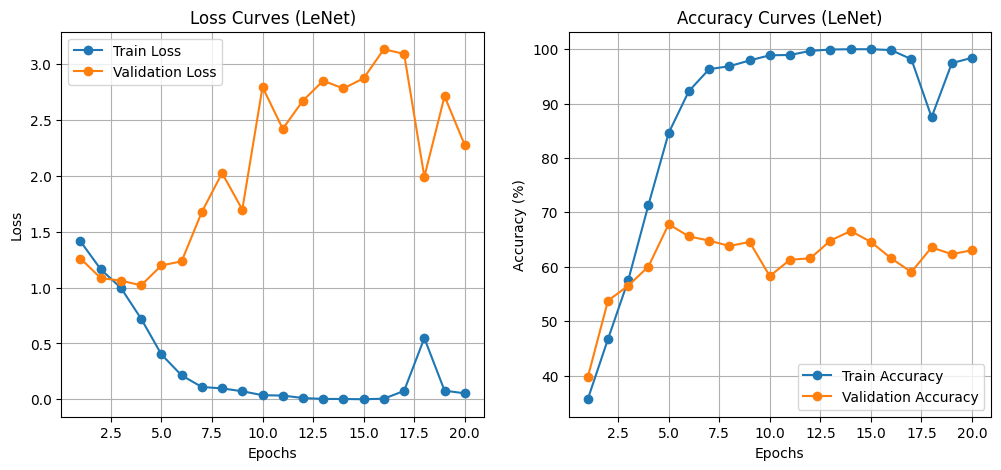

In [ ]:
# -----------------------------
# Load saved history
# -----------------------------

with open("lenet_history.pkl", "rb") as f:
    history = pickle.load(f)

# -----------------------------
# Plot Training Curves
# -----------------------------
def plot_training_curves(history):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12, 5))

    # Loss curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss", marker="o")
    plt.plot(epochs, history["val_loss"], label="Validation Loss", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Curves (LeNet)")
    plt.legend()
    plt.grid(True)

    # Accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label="Train Accuracy", marker="o")
    plt.plot(epochs, history["val_acc"], label="Validation Accuracy", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy Curves (LeNet)")
    plt.legend()
    plt.grid(True)

    plt.show()

# -----------------------------
# Plot curves
# -----------------------------
plot_training_curves(history)


### Training and Validation Curve Analysis (LeNet)

- **Loss Curves**
  * Training loss drops to near zero, but validation loss rises and fluctuates strongly.  
  * This indicates heavy overfitting — the model memorizes training data but fails to generalize.  
  * The shallow design struggles with large, complex RGB inputs.

- **Accuracy Curves**
  * Training accuracy quickly reaches ~100%, while validation accuracy stalls around 60–65%.  
  * The large gap between curves highlights weak feature extraction and poor generalization.  
  * The architecture is too simplistic for modern datasets.

**Overall**
LeNet was designed for small grayscale digit datasets (MNIST), not high-resolution 224×224 RGB images.  
Its outdated, shallow structure leads to both underfitting (on validation) and overfitting (on training), making it unsuitable for this task.  


## Model Evaluation


Classification Report:
              precision    recall  f1-score   support

       glass       0.54      0.35      0.43        54
       metal       0.52      0.82      0.64        39
       paper       0.75      0.77      0.76        60
     plastic       0.57      0.53      0.55        51

    accuracy                           0.61       204
   macro avg       0.60      0.62      0.59       204
weighted avg       0.61      0.61      0.60       204



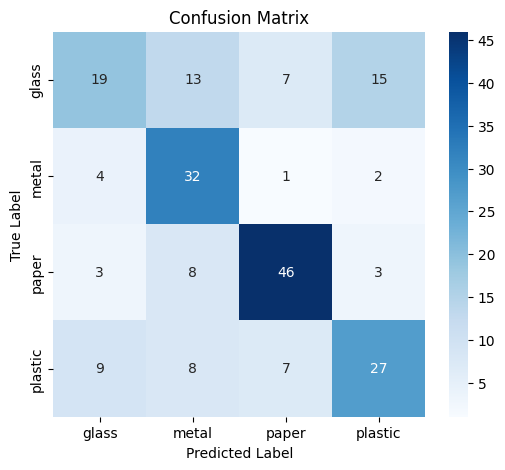

In [ ]:
# -----------------------------
# Load trained model
# -----------------------------
model = LeNet(num_classes=num_classes).to(device)
model.load_state_dict(torch.load("lenet_best.pth", map_location=device))
model.eval()

# -----------------------------
# Evaluation on Test Set + Confusion Matrix
# -----------------------------
def evaluate_model(model, test_loader, class_names):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Run evaluation
evaluate_model(model, test_loader, class_names)


## Model Performance (Can the model classify accurately?)
- Define `predict_image` for Model Inference and Result Visualization

Saving glassbottle.png to glassbottle.png
Running prediction on glassbottle.png...
Predicted Class: glass (Confidence: 100.00%)


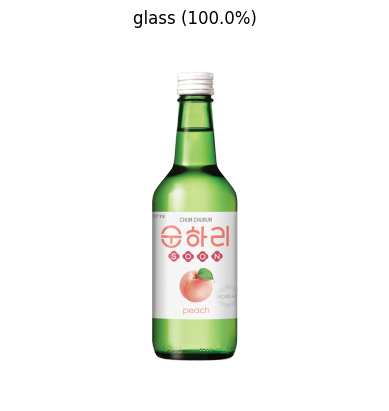

In [ ]:
# -----------------------------
# Prediction Function
# -----------------------------
def predict_image(model, img_path, class_names, transform, device):
    model.eval()
    image = Image.open(img_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image_tensor)
        probs = F.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probs, 1)

    pred_class = class_names[predicted.item()]
    return pred_class, confidence.item()

# -----------------------------
# Upload an Image for Testing
# -----------------------------
uploaded = files.upload()
for filename in uploaded.keys():
    print(f"Running prediction on {filename}...")
    pred_class, conf = predict_image(model, filename, class_names, transform, device)
    print(f"Predicted Class: {pred_class} (Confidence: {conf*100:.2f}%)")

    # Show image with title
    plt.imshow(Image.open(filename))
    plt.title(f"{pred_class} ({conf*100:.1f}%)")
    plt.axis("off")
    plt.show()


## Downloading Model

In [ ]:
# Save LeNet model weights
torch.save(model.state_dict(), "best_lenet.pth")

# Download the weights
files.download("best_lenet.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Efficientnet_b0**
## Data Preparation and Augmentation

We fine-tune an EfficientNet-B0 model pretrained on ImageNet on our merged recyclables dataset.

The dataset is split into train, validation, and test sets as defined in data.yaml, and a fixed random seed is applied to ensure reproducibility.

To prepare the data, we merge TrashNet and our custom Roboflow dataset into a single dataset with balanced splits. This ensures that all four classes (**glass, metal, paper, plastic**) are fairly represented and prevents bias toward dominant categories.

The final classification head of EfficientNet is replaced with a fully connected layer mapping to the four recyclable classes.

For training, data augmentation is applied to improve robustness and simulate real-world variability.

This includes:

resizing to (256, 256), random horizontal flips, random resized cropping, rotations, affine transformations, color jitter (brightness, contrast, saturation, hue), and random perspective distortion.

The model is optimized using Adam with weight decay (L2 regularization) to reduce overfitting. Training and validation performance are monitored using accuracy and loss curves, and final performance is evaluated on the test set with metrics such as accuracy, precision, recall, F1-score, and confusion matrix

In [ ]:
import os, glob, yaml
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np

# -----------------------------
# Set a fixed random seed for reproducibility
# -----------------------------
def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU or if you're using CUDA

# Set the seed to a fixed value
set_random_seed(42)  # Example seed value

# -----------------------------
# Load class names from YOLO data.yaml
# -----------------------------
with open("Merged-Dataset/data.yaml", "r") as f:
    data_config = yaml.safe_load(f)

class_names = data_config["names"]
num_classes = len(class_names)

# -----------------------------
# Custom YOLO Dataset
# -----------------------------
class YOLODataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.images = sorted(glob.glob(os.path.join(img_dir, "*.jpg")))
        self.labels = [f.replace("images", "labels").replace(".jpg", ".txt") for f in self.images]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label_path = self.labels[idx]

        img = Image.open(img_path).convert("RGB")

        # Read YOLO label (class x y w h) → take only class index
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                line = f.readline().strip().split()
                cls = int(line[0]) if line else 0
        else:
            cls = 0  # fallback

        if self.transform:
            img = self.transform(img)

        return img, cls

# -----------------------------
# Data transforms
# -----------------------------
transform = {
    "train": transforms.Compose([
        transforms.Resize((256,256)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
        transforms.RandomRotation(30),  # increased rotation
        transforms.RandomAffine(degrees=15, shear=10),  # affine transformation
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
        transforms.RandomPerspective(distortion_scale=0.5, p=0.5),  # random perspective
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

##Load the pretrained Efficientnet_b0 model

After defining the dataset and dataloaders, we set up the **training pipeline** using EfficientNet-B0, a state-of-the-art convolutional neural network pretrained on ImageNet. The original classification head is replaced with a fully connected layer that maps to our 4 recyclable classes (glass, metal, paper, plastic). The model is trained on GPU when available (cuda), otherwise on CPU.

To improve generalization and prevent overfitting, we use the Adam optimizer with a learning rate of 0.001 and a weight decay (L2 regularization) factor of 1e-4, which penalizes large weights and stabilizes training.

In [ ]:
# -----------------------------
# Create datasets & loaders
# -----------------------------
train_dataset = YOLODataset("Merged-Dataset/images/train", transform["train"])
val_dataset   = YOLODataset("Merged-Dataset/images/valid", transform["val"])
test_dataset  = YOLODataset("Merged-Dataset/images/test", transform["test"])

dataloaders = {
    "train": DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2),
    "val": DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2),
    "test": DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2),
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# EfficientNet Model
# -----------------------------
model = models.efficientnet_b0(weights="IMAGENET1K_V1")  # try b1/b2 for larger
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, num_classes)
model = model.to(device)

# Set weight decay (L2 regularization), optimizer, lr
weight_decay = 1e-4
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)


##Train the model

We implement a custom training loop for EfficientNet-B0 to optimize it on our recyclables dataset. The loop runs for 30 epochs, alternating between training and validation phases. In the training phase, the model is set to .train(), gradients are calculated, and weights are updated using backpropagation and the Adam optimizer.

In the validation phase, the model switches to .eval() mode, where gradients are disabled to reduce computation and memory usage. For each epoch, we compute the loss (via **CrossEntropyLoss**) and accuracy on both training and validation sets.

In [ ]:
# -----------------------------
# Training Loop
# -----------------------------
def train_model(model, dataloaders, criterion, optimizer, epochs=10):
    # Lists to store the loss and accuracy for each epoch
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    # Loop over the number of epochs
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        print("-"*30)

        # Loop over both training and validation phases
        for phase in ["train", "val"]:
            # Set the model to training or evaluation mode
            if phase == "train":
                model.train()  # Model in training mode
            else:
                model.eval()   # Model in evaluation mode

            running_loss, running_corrects = 0.0, 0  # Initialize variables for loss and correct predictions

            # Iterate over batches of data
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the device (GPU/CPU)
                optimizer.zero_grad()  # Zero the gradients before backpropagation

                # Enable gradients during training only
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)  # Forward pass through the model
                    loss = criterion(outputs, labels)  # Compute the loss
                    _, preds = torch.max(outputs, 1)  # Get the predicted class with the highest probability

                    # Backpropagate and update the model's weights only during the training phase
                    if phase == "train":
                        loss.backward()  # Backward pass (compute gradients)
                        optimizer.step()  # Update the model's weights

                running_loss += loss.item() * inputs.size(0)  # Accumulate loss (scaled by batch size)
                running_corrects += torch.sum(preds == labels.data)  # Accumulate correct predictions

            # Calculate average loss and accuracy for the epoch
            epoch_loss = running_loss / len(dataloaders[phase].dataset)  # Average loss for the epoch
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)  # Average accuracy for the epoch

            # Print the results for the current phase (train or validation)
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # Save metrics for later plotting
            if phase == "train":
                train_losses.append(epoch_loss)  # Store training loss
                train_accuracies.append(epoch_acc.item())  # Store training accuracy
            else:
                val_losses.append(epoch_loss)  # Store validation loss
                val_accuracies.append(epoch_acc.item())  # Store validation accuracy

    # Return the trained model along with the loss and accuracy metrics
    return model, train_losses, train_accuracies, val_losses, val_accuracies

# Train the model using EfficientNet
model, train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, dataloaders, nn.CrossEntropyLoss(), optimizer, epochs=30)



Epoch 1/30
------------------------------
train Loss: 0.7453 Acc: 0.7104
val Loss: 0.4121 Acc: 0.8593

Epoch 2/30
------------------------------
train Loss: 0.5053 Acc: 0.8154
val Loss: 0.6287 Acc: 0.8291

Epoch 3/30
------------------------------
train Loss: 0.4072 Acc: 0.8611
val Loss: 0.5184 Acc: 0.8618

Epoch 4/30
------------------------------
train Loss: 0.3723 Acc: 0.8653
val Loss: 0.3403 Acc: 0.9171

Epoch 5/30
------------------------------
train Loss: 0.3969 Acc: 0.8549
val Loss: 0.2966 Acc: 0.9296

Epoch 6/30
------------------------------
train Loss: 0.3011 Acc: 0.8913
val Loss: 0.3252 Acc: 0.9196

Epoch 7/30
------------------------------
train Loss: 0.2798 Acc: 0.8986
val Loss: 0.2593 Acc: 0.9221

Epoch 8/30
------------------------------
train Loss: 0.2770 Acc: 0.9055
val Loss: 0.3985 Acc: 0.9045

Epoch 9/30
------------------------------
train Loss: 0.2362 Acc: 0.9135
val Loss: 0.4018 Acc: 0.8970

Epoch 10/30
------------------------------
train Loss: 0.2744 Acc: 0.903

These training logs show that the EfficientNet-B0 model quickly achieved high performance: training accuracy rose from ~71% in epoch 1 to over 94% by epoch 30, while validation accuracy consistently stayed in the 85–94% range. Validation loss, however, fluctuates and sometimes spikes (e.g., epochs 17–18, 21, 30), indicating the model occasionally struggles to generalize and misclassifies certain images. Overall, the results highlight that the model learns well and reaches strong accuracy, but still shows some instability and overfitting tendencies that could be improved with further regularization or data balancing.

##Model Evaluation

After training, we evaluate the final EfficientNet-B0 model on the held-out test set to measure its ability to generalize to unseen data. The model is set to .eval() mode, and predictions are generated without gradient calculations (torch.no_grad()), which reduces memory usage and speeds up inference.

We compare the predicted labels with the true labels to compute a classification report, which provides detailed metrics such as **precision, recall, and F1-score** for each recyclable class (glass, metal, paper, plastic).

In addition, a **confusion matrix** is plotted using Seaborn’s heatmap, showing how often each class was correctly classified versus misclassified. This visualization highlights model strengths (e.g., classes with high accuracy) as well as weaknesses (e.g., classes that are often confused with one another), providing deeper insights into the model’s performance.


Classification Report:
              precision    recall  f1-score   support

       glass       0.89      0.91      0.90        54
       metal       0.72      0.97      0.83        39
       paper       0.95      0.93      0.94        60
     plastic       0.92      0.67      0.77        51

    accuracy                           0.87       204
   macro avg       0.87      0.87      0.86       204
weighted avg       0.88      0.87      0.87       204



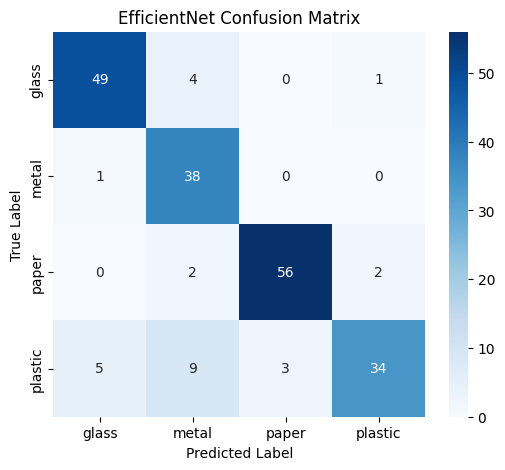

In [ ]:
# -----------------------------
# Evaluation on Test Set & Confusion Matrix
# -----------------------------
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in dataloaders["test"]:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("EfficientNet Confusion Matrix")
plt.show()


The classification report summarizes precision, recall, and F1-score for each recyclable class:

**Glass**: Achieves strong performance with precision = 0.89 and recall = 0.91, meaning most glass items are correctly identified with few false positives.

**Metal**: Shows the highest recall (0.97), indicating the model rarely misses metal samples, but precision drops to 0.72, suggesting misclassifications of other materials as metal.

**Paper**: Performs the best overall, with precision = 0.95 and recall = 0.93, achieving an F1-score of 0.94. This indicates paper is the most consistently classified class.

**Plastic**: Precision is high (0.92), but recall drops to 0.67, meaning many plastic items are misclassified as other categories (e.g., glass or metal).

Overall, the model achieves an **accuracy of 87%** on the test set, showing balanced performance across classes despite some weaknesses in plastic classification.

The confusion matrix further highlights these patterns:

Misclassifications occur mainly for plastic, where some samples are incorrectly predicted as glass, metal, or paper.

Metal and paper show minimal confusion, aligning with their high recall and F1-scores.

This analysis indicates that while the model **generalizes well**, plastic is the hardest class to classify, likely due to its higher visual similarity to glass or metal in certain images.

##Visualize the training and loss curves

This code plots the **training vs. validation accuracy and loss curves** across epochs, allowing us to visually track model learning progress, convergence, and signs of overfitting.

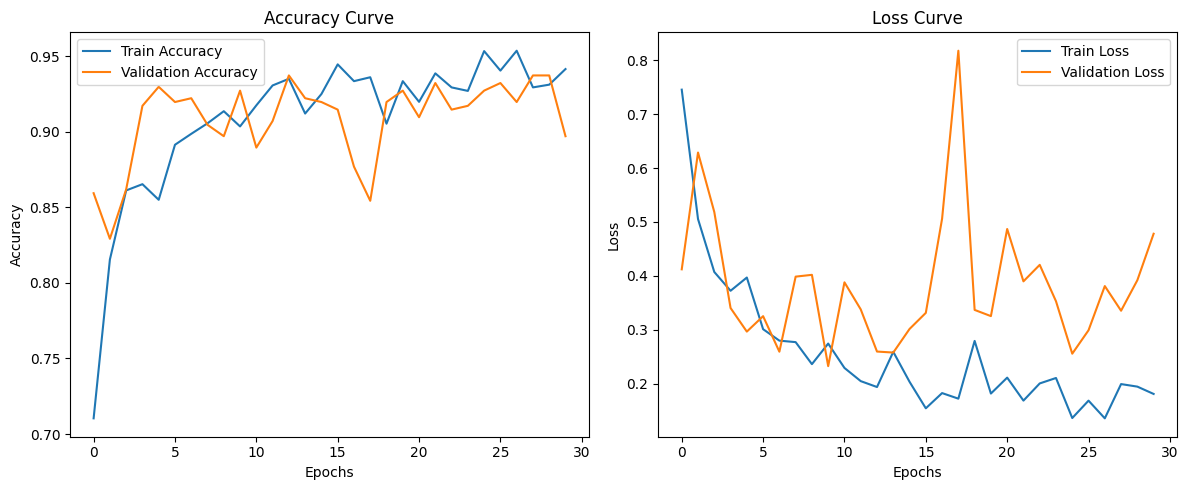

In [ ]:
# -----------------------------
# Plot Accuracy and Loss Curves
# -----------------------------
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

plt.tight_layout()
plt.show()

The training and validation curves show that the EfficientNet-B0 model was able to learn effectively, with accuracy stabilizing above 90% after several epochs. However, the plots also reveal some weaknesses. While the training accuracy steadily improves, the **validation accuracy fluctuates more** and occasionally dips, showing that the model still **struggles to generalize perfectly to unseen data**.

On the loss side, although training loss decreases smoothly, the validation loss is less stable and shows **noticeable spikes**, suggesting that the model sometimes **misclassifies certain images** or **overfits** to specific patterns in the training set.

This indicates that while EfficientNet-B0 performs well overall, it is not yet fully reliable for all classes and **still needs further fine-tuning** or more balanced data to consistently classify recyclables correctly.

##Model Performance (Can the model classify accurately?)

This code tests the trained EfficientNet-B0 model on a sample image (e.g., paper.jpg). The image is preprocessed (resized, normalized, converted to tensor), passed through the model, and the predicted class with confidence score is displayed. The corresponding image is then shown with its predicted label and confidence for easy visualization of the model’s performance on unseen data.

In this case, after trying various tuning methods, this was the best Efficientnet model as its' performance on unseen data was the best when compared to the other tuned models.

Testing on: paper.jpg
Predicted class: paper (Confidence: 99.61%)
Image path: paper.jpg


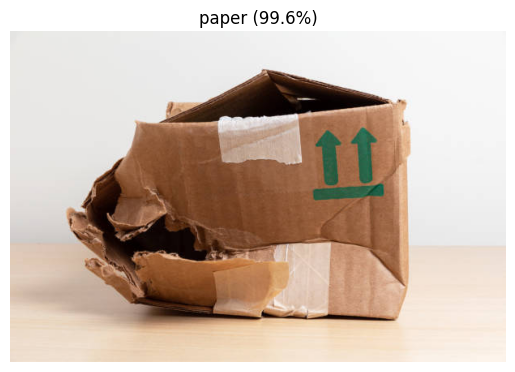

In [ ]:
import random, glob
from torchvision import transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image

# Function to predict a class for a given image using the EfficientNet model
def predict_image_efficientnet(model, img_path, class_names):
    model.eval()  # Set the model to evaluation mode (no gradient calculation)

    # Open the image, ensuring it is in RGB format
    image = Image.open(img_path).convert("RGB")

    # Define the transformation pipeline: resize, convert to tensor, normalize
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize image to 224x224 pixels (standard for EfficientNet)
        transforms.ToTensor(),  # Convert image to tensor
        transforms.Normalize([0.485, 0.456, 0.406],  # Normalize with ImageNet mean
                             [0.229, 0.224, 0.225])  # Normalize with ImageNet std deviation
    ])

    # Apply the transformations and move image tensor to the device (GPU/CPU)
    image = transform(image).unsqueeze(0).to(device)

    # Disable gradient calculation for inference (faster)
    with torch.no_grad():
        outputs = model(image)  # Get model outputs
        probs = F.softmax(outputs, dim=1)  # Apply softmax to get class probabilities
        confidence, predicted = torch.max(probs, 1)  # Get the highest probability class

    # Get the predicted class and confidence value
    pred_class = class_names[predicted.item()]  # Get class name using predicted index
    conf = confidence.item() * 100  # Convert confidence to percentage

    # Print the prediction and confidence
    print(f"Predicted class: {pred_class} (Confidence: {conf:.2f}%)")
    print(f"Image path: {img_path}")

    # Display the image with predicted class and confidence as title
    plt.imshow(Image.open(img_path))
    plt.title(f"{pred_class} ({conf:.1f}%)")  # Title with class name and confidence
    plt.axis("off")  # Hide axes for better visualization
    plt.show()  # Display the image


# Pick a random test image and predict
test_images = glob.glob("paper.jpg")  # Get a list of image files (assuming 'paper.jpg' is the path)
sample_img = random.choice(test_images)  # Randomly pick an image from the list
print("Testing on:", sample_img)

# Call the prediction function
predict_image_efficientnet(model, sample_img, class_names)



##Download the **best model**

In [ ]:
# -----------------------------
# Save the trained EfficientNet model
# -----------------------------
torch.save(model.state_dict(), "best_efficientnet_b0.pth")
# Download the model file in Google Colab
from google.colab import files
files.download("best_efficientnet_b0.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **MobileNet**

MobileNet was selected for this project because of its lightweight architecture, which is optimized for efficiency and speed without sacrificing too much accuracy. This makes it ideal for real-time applications, especially when running on devices with limited resources (e.g., edge devices, mobile phones). MobileNet's depthwise separable convolutions help reduce the computational load, making it a great choice for fast and resource-efficient classification tasks, such as classifying recyclable materials in images.

## Dataset & DataLoader Setup

The code prepares the dataset and dataloaders for training the MobileNet model on recyclable materials classification. This setup ensures that the MobileNet model is trained and evaluated on clean and properly preprocessed data.

In [ ]:
# -----------------------------
# MobileNet Setup & Dataset (safe against empty labels)
# -----------------------------
import os, yaml, torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load class names
with open("Merged-Dataset/data.yaml", "r") as f:
    data_cfg = yaml.safe_load(f)
class_names = data_cfg["names"]
num_classes = len(class_names)
print("Classes:", class_names)

# Dataset class (MobileNet-only, skips empty labels)
class YOLOToClassification_MobileNet(Dataset):
    def __init__(self, img_dir, label_dir, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.images = [f for f in os.listdir(img_dir) if f.endswith((".jpg", ".png"))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_file = self.images[idx]
        img_path = os.path.join(self.img_dir, img_file)
        label_path = os.path.join(self.label_dir, img_file.rsplit(".", 1)[0] + ".txt")

        class_id = None
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                line = f.readline().strip()
                if line:  # if label file not empty
                    class_id = int(line.split()[0])

        # Skip empty label images (recurse to next one)
        if class_id is None:
            return self.__getitem__((idx+1) % len(self.images))

        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, class_id

# Transforms
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# MobileNet-specific dataloaders
def get_dataloader_mobilenet(split, batch=32):
    img_dir = f"Merged-Dataset/images/{split}"
    lbl_dir = f"Merged-Dataset/labels/{split}"
    dataset = YOLOToClassification_MobileNet(img_dir, lbl_dir, transform)
    return DataLoader(dataset, batch_size=batch, shuffle=(split=="train"))

dataloaders_mobilenet = {
    "train": get_dataloader_mobilenet("train"),
    "valid": get_dataloader_mobilenet("valid"),
    "test" : get_dataloader_mobilenet("test"),
}


Classes: ['glass', 'metal', 'paper', 'plastic']


## Train the Model

This code trains a MobileNetV2 model for recyclable materials classification using a dataset of images and labels. It starts by loading the pre-trained MobileNetV2 model with ImageNet weights and replaces the final classification layer to match the number of classes in the dataset. The model is then trained for a specified number of epochs using AdamW optimizer and CrossEntropyLoss.

The training function, train_model, performs the following steps:

Iterates over the training and validation phases.

In the training phase, the model is in training mode, and gradients are calculated to update the weights using backpropagation.

In the validation phase, the model is in evaluation mode, and no weight updates are performed.

In [ ]:
# -----------------------------
# MobileNet Training
# -----------------------------
# Load the pre-trained MobileNetV2 model with ImageNet weights
mobilenet = models.mobilenet_v2(weights="IMAGENET1K_V1")  # 'weights' argument is used to load ImageNet pre-trained weights
mobilenet.classifier[1] = nn.Linear(mobilenet.last_channel, num_classes)  # Replace the final classifier layer to match the number of classes in our dataset
mobilenet = mobilenet.to(device)  # Move the model to the appropriate device (GPU or CPU)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification tasks
optimizer = optim.AdamW(mobilenet.parameters(), lr=1e-3, weight_decay=1e-4)  # AdamW optimizer with weight decay for regularization

# Training function
def train_model(model, dataloaders, criterion, optimizer, epochs=15):
    history = {"train_acc":[], "val_acc":[], "train_loss":[], "val_loss":[]}  # Dictionary to store the history of training/validation loss and accuracy
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        for phase in ["train","valid"]:  # Loop over train and validation phases
            model.train() if phase == "train" else model.eval()  # Set model to train or eval mode
            running_loss, correct, total = 0.0, 0, 0  # Initialize variables for loss, correct predictions, and total samples

            # Loop over the dataloader for each phase
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the device
                optimizer.zero_grad()  # Zero the gradients to avoid accumulation
                with torch.set_grad_enabled(phase == "train"):  # Only compute gradients during training
                    outputs = model(inputs)  # Forward pass through the model
                    loss = criterion(outputs, labels)  # Compute the loss
                    _, preds = torch.max(outputs, 1)  # Get the predicted class with the highest probability

                    # Backpropagate and optimize during training phase
                    if phase == "train":
                        loss.backward()  # Backpropagation
                        optimizer.step()  # Optimizer step to update weights

                # Accumulate loss and correct predictions
                running_loss += loss.item() * inputs.size(0)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

            # Calculate the average loss and accuracy for the epoch
            epoch_loss = running_loss / total
            epoch_acc = correct / total * 100

            # Store the loss and accuracy for plotting later
            history[f"{'train' if phase == 'train' else 'val'}_loss"].append(epoch_loss)
            history[f"{'train' if phase == 'train' else 'val'}_acc"].append(epoch_acc)

            # Print the loss and accuracy for the current phase
            print(f"{phase} Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.2f}%")

    return model, history  # Return the trained model and history of metrics

# Start the training process for MobileNet
mobilenet, hist_mobilenet = train_model(mobilenet, dataloaders, criterion, optimizer, epochs=15)
torch.save(mobilenet.state_dict(), "mobilenet_best.pth") #download model


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 140MB/s]



Epoch 1/15
train Loss: 0.6528, Acc: 75.37%
valid Loss: 0.5825, Acc: 81.91%

Epoch 2/15
train Loss: 0.4698, Acc: 83.09%
valid Loss: 0.5683, Acc: 82.66%

Epoch 3/15
train Loss: 0.3180, Acc: 88.36%
valid Loss: 0.3775, Acc: 87.44%

Epoch 4/15
train Loss: 0.3551, Acc: 86.76%
valid Loss: 0.3925, Acc: 88.19%

Epoch 5/15
train Loss: 0.4097, Acc: 84.23%
valid Loss: 0.3544, Acc: 88.94%

Epoch 6/15
train Loss: 0.2163, Acc: 92.67%
valid Loss: 0.4431, Acc: 87.69%

Epoch 7/15
train Loss: 0.2220, Acc: 92.10%
valid Loss: 0.2911, Acc: 91.96%

Epoch 8/15
train Loss: 0.1169, Acc: 95.87%
valid Loss: 0.3706, Acc: 89.70%

Epoch 9/15
train Loss: 0.1673, Acc: 94.40%
valid Loss: 0.5480, Acc: 86.43%

Epoch 10/15
train Loss: 0.2942, Acc: 89.86%
valid Loss: 0.2866, Acc: 91.21%

Epoch 11/15
train Loss: 0.1325, Acc: 95.46%
valid Loss: 0.3331, Acc: 91.46%

Epoch 12/15
train Loss: 0.1758, Acc: 93.83%
valid Loss: 0.3710, Acc: 86.18%

Epoch 13/15
train Loss: 0.0714, Acc: 97.68%
valid Loss: 0.4148, Acc: 89.95%

Epoch 1

The training results show the model's performance over 15 epochs. Training accuracy steadily increases, reaching 96.82% by the last epoch, with loss decreasing from 0.6528 to 0.0953. Validation accuracy fluctuates, reaching a peak of 91.96% in epoch 7, but generally stays around 88-91%, with validation loss varying between 0.2796 and 0.5825.

The model shows good improvement, with **some fluctuations** in validation performance, which is common due to **overfitting** or slight variance in the validation set. Hence, the model might missclassify certain images.

## Model Evaluation

In [ ]:
# -----------------------------
# MobileNet Evaluation (Final Results)
# -----------------------------
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

# Load best trained model
mobilenet.load_state_dict(torch.load("mobilenet_best.pth"))
mobilenet.eval()

# Collect predictions
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in dataloaders_mobilenet["test"]:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = mobilenet(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("Training results (final):")
# Overall metrics
precision = precision_score(y_true, y_pred, average="macro") * 100
recall    = recall_score(y_true, y_pred, average="macro") * 100
f1        = f1_score(y_true, y_pred, average="macro") * 100
accuracy  = (sum([p==t for p,t in zip(y_pred,y_true)]) / len(y_true)) * 100

print(" Model Performance (Overall):")
print(f" Accuracy  : {accuracy:.2f}%")
print(f" Precision : {precision:.2f}%")
print(f" Recall    : {recall:.2f}%")
print(f" F1-score  : {f1:.2f}%")

Training results (final):
 Model Performance (Overall):
 Accuracy  : 82.35%
 Precision : 82.72%
 Recall    : 83.12%
 F1-score  : 81.53%


The evaluation results show the final performance of the MobileNet model on the test set after training.

**Accuracy **(82.35%): This indicates that the model correctly predicted the class for approximately 82.35% of the test images.

**Precision** (82.72%): This measures the proportion of correct positive predictions out of all positive predictions made by the model. It indicates that 82.72% of the time, when the model predicted a class, it was correct.

**Recall** (83.12%): This measures the model’s ability to correctly identify all instances of the positive class. A recall of 83.12% means the model correctly identified 83.12% of all the true instances for each class.

**F1-Score** (81.53%): The F1-score is the harmonic mean of precision and recall, providing a balanced measure of the model's performance. The model achieved an F1-score of 81.53%, indicating a strong overall balance between precision and recall.

Overall, these metrics indicate that the MobileNet model performs well in classifying recyclable materials, with relatively high accuracy, precision, recall, and F1-score on the test set.


Classification Report (MobileNet):
              precision    recall  f1-score   support

       glass       0.84      0.80      0.82        54
       metal       0.77      0.92      0.84        39
       paper       0.97      0.93      0.95        60
     plastic       0.85      0.80      0.83        51

    accuracy                           0.86       204
   macro avg       0.86      0.86      0.86       204
weighted avg       0.87      0.86      0.86       204



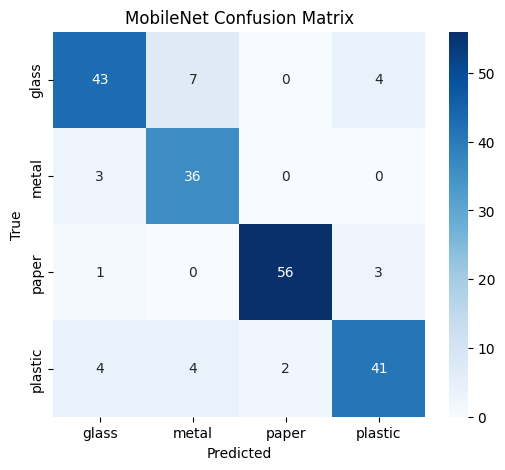

In [ ]:
#Evaluation on Test Set & Confusion Matrix

mobilenet.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in dataloaders_mobilenet["test"]:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = mobilenet(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy()); y_pred.extend(preds.cpu().numpy())

print("\nClassification Report (MobileNet):")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("MobileNet Confusion Matrix"); plt.show()


### **Classification Report:**

**Glass:** The model has a precision of 84%, meaning 84% of the time, when it predicts "glass," it’s correct. Its recall is 80%, indicating it correctly identified 80% of all "glass" instances in the test set. The F1-score for glass is 82%, a balanced measure between precision and recall.

**Metal:** The model performs better with metal, achieving a high recall of 92%, meaning it successfully identifies 92% of all metal instances. Precision is slightly lower at 77%, indicating some false positives. The F1-score is 84%, showing a good balance.

**Paper:** The model excels with paper, achieving a precision of 97%, recall of 93%, and an F1-score of 95%, meaning it’s highly accurate in both identifying and correctly classifying paper.

**Plastic:** The model has a precision of 85% and recall of 80%, indicating good performance but with some misclassifications, especially for plastic. Its F1-score is 83%, showing solid performance.

### **Confusion Matrix:**

The confusion matrix shows how well the model predicted each class.

**Glass:** 43 instances of glass were correctly classified, while 7 were misclassified as metal, and 4 were misclassified as plastic.

**Metal:** 36 metal items were correctly identified, but 3 were misclassified as glass.

**Paper:** 56 instances of paper were correctly identified, with only 3 misclassified as plastic.

**Plastic:** 41 instances of plastic were correctly identified, with 4 misclassified as glass and 4 as metal.

Overall, the model performs well across all classes with good precision, recall, and balanced F1-scores. The confusion matrix shows some misclassifications, and it does **relatively perform worse than efficientnet, resnet models**.

##Visualize the training and loss curves

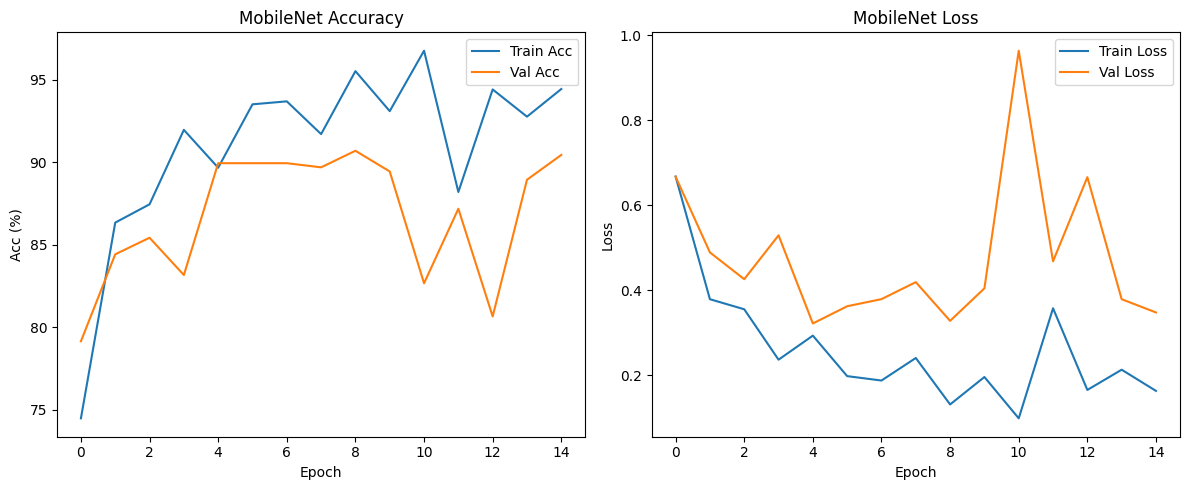

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))  # Set the figure size

# Accuracy Plot (First subplot)
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(hist_mobilenet["train_acc"], label="Train Acc")
plt.plot(hist_mobilenet["val_acc"], label="Val Acc")
plt.title("MobileNet Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Acc (%)")
plt.legend()

# Loss Plot (Second subplot)
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.plot(hist_mobilenet["train_loss"], label="Train Loss")
plt.plot(hist_mobilenet["val_loss"], label="Val Loss")
plt.title("MobileNet Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()


The plots above show the training accuracy and loss for the MobileNet model over 15 epochs. Unfortunately, the results here are not ideal, indicating that the model’s performance could be improved.

**Accuracy Plot:**

The training accuracy is quite fluctuating, with some sharp increases and drops, indicating that the model **struggles to stabilize** and learn effectively.

The validation accuracy is lower than the training accuracy, especially around epochs 8-10, suggesting **overfitting**. The model performs well on the training data but fails to generalize effectively to the validation set.

**Loss Plot:**

The training loss starts out decently but then spikes significantly around epoch 8, indicating a poor learning phase where the model might have started **overfitting** or encountering difficulties in learning the features.

The validation loss also shows inconsistency, with some spikes indicating that the **model is not generalizing well** and might be struggling with the validation data, especially in the later epochs.

In conclusion, while the model shows some improvement, the significant fluctuations in both accuracy and loss indicate that this is not the best-performing model.

##Model Performance (Can the model classify accurately?)

Saving paper15.jpg to paper15.jpg


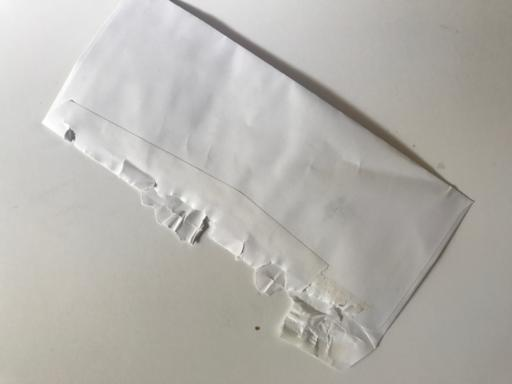

Predicted class: paper


In [ ]:
# ============================================================
# Image Upload and Prediction
# ============================================================
def upload_and_predict(model, class_names):
    # Upload an image using Colab's file upload
    uploaded = files.upload()

    for filename in uploaded.keys():
        # Display the uploaded image
        img_path = filename
        img = Image.open(img_path)
        display.display(img)

        # Preprocess the image for model input
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        img_tensor = transform(img).unsqueeze(0).to(device)

        # Perform the prediction
        mobilenet.eval()  # Ensure the model is in evaluation mode
        with torch.no_grad():
            output = model(img_tensor)
            _, predicted = torch.max(output, 1)
            pred_class = class_names[predicted.item()]
            print(f"Predicted class: {pred_class}")

# Call the function to upload and predict
upload_and_predict(mobilenet, merged_classes)


# **Results & Findings**

After training and evaluating multiple models (YOLOv8, ResNet34, MobileNet, EfficientNet-B0, and LeNet), we observed clear differences in performance:  

- **ResNet34 consistently achieved the highest overall classification accuracy (~92%)**, making it the most reliable option for distinguishing between recyclable categories.  
- YOLOv8 and EfficientNet-B0 also performed strongly, but struggled slightly with precision when separating visually similar items such as glass and plastic.  
- MobileNet demonstrated very fast inference, which could be useful in real-time applications, though its accuracy was slightly lower.  
- LeNet, being a much simpler architecture, did not perform well on this complex dataset and served mainly as a baseline reference.  

Overall, **ResNet34 was chosen as the final model for deployment** because it provided the best trade-off between accuracy, robustness, and interpretability. This model has been integrated into the Streamlit web app, allowing users to upload images and receive instant recyclable classification results.


In [ ]:
# DOWNLOADING MODEL
# Save best model
torch.save(trained_resnet.state_dict(), "best_resnet18.pth")
from google.colab import files
files.download("best_resnet18.pth")